In [1]:
import numpy as np
from scipy.fft import fft2,fftshift
from scipy.fft import ifft2,ifftshift
from scipy.fft import fftfreq
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import spherical_jn, spherical_yn , hankel1,lpmv
import cmath

In [2]:
def MieCoef(x, M, n):
    # Computing spherical Bessel functions for n and M*n
    j_n_x = spherical_jn(n, x)
    j_n_Mx = spherical_jn(n, M*x)

    # Computing Riccati-Bessel functions
    psi_n_x = x * j_n_x
    zeta_n_x = x * cmath.sqrt(np.pi/(2*x))*hankel1(n+1/2,x)

    psi_n_Mx = M * x * j_n_Mx
    zeta_n_Mx = M * x * cmath.sqrt(np.pi/(2*M*x))*hankel1(n+1/2,M*x)

    # Computing Riccati-Bessel function derivatives using numdifftools
    #psi_n_x_prime = nd.Derivative(lambda x: x * spherical_jn(n, x), n=1, order=1)(x)
    psi_n_x_prime = 1/2* (  x* (spherical_jn(n-1,x)-spherical_jn(n+1,x)) + spherical_jn(n,x) ) 
    
    zeta_n_x_prime = 1/2* cmath.sqrt(np.pi/(2*x))*(  x* (hankel1(n+1/2-1,x)-hankel1(n+1/2+1,x)) + hankel1(n+1/2,x) )

    #psi_n_Mx_prime = nd.Derivative(lambda x: M * x * spherical_jn(n, M * x), n=1, order=1)(x)
    psi_n_Mx_prime = 1/2* (  M*x* (spherical_jn(n-1,M*x)-spherical_jn(n+1,M*x)) + spherical_jn(n,M*x) ) 
    
    zeta_n_Mx_prime= 1/2* cmath.sqrt(np.pi/(2*M*x))*(  x* (hankel1(n+1/2-1,M*x)-hankel1(n+1/2+1,M*x)) + hankel1(n+1/2,M*x) )

    # Calculating coefficients a_n, b_n, c_n, d_n
    a_n = (M * psi_n_Mx * psi_n_x_prime - psi_n_Mx_prime * psi_n_x) / (psi_n_Mx_prime * zeta_n_x - M * psi_n_Mx * zeta_n_x_prime)
    b_n = (M * psi_n_Mx_prime * psi_n_x - psi_n_Mx * psi_n_x_prime) / (psi_n_Mx * zeta_n_x_prime - M * psi_n_Mx_prime * zeta_n_x)
    
    #c_n = (psi_n_x * zeta_n_x_prime - psi_n_x_prime * zeta_n_x) / (psi_n_Mx_prime * zeta_n_x - M * psi_n_Mx * zeta_n_x_prime)
    #d_n = (psi_n_x_prime * zeta_n_x - psi_n_x * zeta_n_x_prime) / (psi_n_Mx * zeta_n_x_prime - M * psi_n_Mx_prime * zeta_n_x)

    return a_n, b_n

def MieCoefCond2(x, n, k1):
    jn = spherical_jn(n, x)
    jn1 = spherical_jn(n+1,x)
    jn_1 = spherical_jn(n-1,x)
    
    hankeln = np.sqrt(np.pi/(2*x))*hankel1(n+1/2,x)
    hankeln1 = np.sqrt(np.pi/(2*x))*hankel1(n+1+1/2,x)
    hankeln_1 = np.sqrt(np.pi/(2*x))*hankel1(n-1+1/2,x)
    
    a = -(jn + x *1/2* (  x* (jn_1-jn1) + jn ))/(hankeln + x  *1/2* ( x*(hankeln_1-hankeln1) + hankeln))

    b = - jn/hankeln  

    
    return a, b


def E1_SCATnm(n, a_n, b_n, k, x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.sign(y) * np.arccos(x/np.sqrt(x**2+y**2))
    theta = np.arccos(z / r)

    kr = k * r
    hn = np.sqrt(np.pi / (2 * kr)) * hankel1(n + 1 / 2, kr)
    hn1 = np.sqrt(np.pi / (2 * kr)) * hankel1(n + 1 / 2 + 1, kr)
    Pn1 = lpmv(1, n + 1, np.cos(theta))
    Pn = lpmv(1, n, np.cos(theta))

    dP = (n * Pn1 - (n + 1) * np.cos(theta) * Pn) / np.sin(theta)
    P = Pn / np.sin(theta)

    # Replace zero values of dP and P at theta=0 with -1/2*n*(n+1)

    zero_theta_indices = (np.where(abs(theta) < 10**(-10))[0])
    dP[zero_theta_indices] = -0.5 * n * (n + 1)
    P[zero_theta_indices] = -0.5 * n * (n + 1)

    zero_theta_indices = (np.isnan(phi))
    phi[zero_theta_indices] = 0
    
    Gn = 1j**n
    prefac = -Gn / (n * (n + 1)) * (2 * n + 1) * 1j

    term_r = -a_n / kr * hn * Pn * n * (n + 1) * np.cos(phi)
    term_the = (-a_n / kr * ((n + 1) * hn - kr * hn1) * dP - 1j * b_n * hn * P) * np.cos(phi)
    term_phi = (a_n / kr * ((n + 1) * hn - kr * hn1) * P + 1j * b_n * hn * dP) * np.sin(phi)

    return prefac * (np.array([term_r * np.cos(phi) * np.sin(theta), term_r * np.sin(theta) * np.sin(phi), term_r * np.cos(theta)]) +
                     np.array([term_the * np.cos(phi) * np.cos(theta), term_the * np.cos(theta) * np.sin(phi), -term_the * np.sin(theta)]) +
                     np.array([-term_phi * np.sin(phi), term_phi * np.cos(phi), np.zeros_like(r)]))


In [3]:
def Optica(U0,X,Y,z,lamb):
    A = (fft2((U0)))
    
    Lx = np.max(X)
    Ly= np.max(Y)

    deltax = 2*Lx/len(U0)
    deltay = 2*Ly/len(U0)    

    fx = ( fftfreq(len(U0),deltax) )  
    fy = ( fftfreq(len(U0),deltay) )   
    
    Fx,Fy = np.meshgrid(fx,fy)
    K = 2*np.pi/lamb

    # Handle cases where u is negative
    u = K**2-(2*np.pi*Fx)**2-(2*np.pi*Fy)**2
    sqrt_u = 1j*z*np.sqrt(abs(u))
    sqrt_u[np.where(u<0)] = 1j*sqrt_u[np.where(u<0)]

    return  ( ifft2( ( A*np.exp(sqrt_u) ) ) )


def Optica_G(U0,X,Y,lamb,L,z):
    A= 1
    for i in range(len(L)):
      A =  Optica(A*U0[i],X,Y,L[i],lamb)

    return Optica(A*U0[-1],X,Y,z,lamb)

def mask_esp(X,Y,R,n):
  n=n+2
  U0,L =[],np.arange(1,n-1,1)*2*R/(n-1)
  for i in L:
    U0.append( (X**2+Y**2>R**2 - (i - R)**2).astype(float))

  return U0,np.ones(n-3)*L[0]


def FiguraOptica(U0,X,Y,lamb,L,z):
  A= 1
  Z=[]
  #A =  Optica(A,X,Y,L[0],lamb)
  for i in range(len(L)):
    A =  Optica(A*U0[i],X,Y,L[i],lamb)

  for i in range(len(z)):
    U = Optica(A*U0[-1],X,Y,z[i],lamb)
    Z.append(abs(U[len(A[0])//2])**2)
  return Z

In [4]:

def Optica_G0(X,Y,lamb,z,R):
    A= 1
    zz =np.arange(0,2*R, abs(X[0][0]-X[0][1]))
    print(len(zz))
    
    for i in range(0,len(zz)):
      U0 = (X**2+Y**2>R**2 - (zz[i] - R)**2).astype(float)
      A =  Optica(A*U0,X,Y,abs(zz[0]-zz[1]),lamb)

    U0 = (X**2+Y**2>R**2 - (zz[-1] - R)**2).astype(float)
    return Optica(A*U0,X,Y,z,lamb)


In [5]:
R1= 1000#1*u.mm

lamb = 0.632#633*u.nm
z= np.array([500,1e3,2*1e3,4*1e3,6*1e3,7*1e3,8*1e3,9*1e3,1e4])*10#100*u.mm
N = [512,2000,4096]
vard = 9

# Concatenate the arrays together
U115=[]
x0=[]
for u in range(len(N)):
    x0_ = np.linspace(-vard*R1,vard*R1,N[u],endpoint=False)#*u.mm
    X,Y = np.meshgrid(x0_,x0_)

    n = 11
    #U015 = Optica_G0(X,Y,lamb,z,R1)
    A,L = mask_esp(X,Y,R1,n)
    #U015 = Optica_G(A,X,Y,lamb,L,z-R1+L[0])
    U015 = FiguraOptica(A,X,Y,lamb,L,z - R1 + L[0]*( len(L)//2 ))
    U115.append(U015)
    x0.append(x0_)
#A = (X**2+Y**2>R1**2).astype('float32')
#U= Optica(A,X,Y,z,lamb)

In [ ]:
# Constants
N0 = 200000
k = 2 * np.pi / lamb
x_value = k * R1
M = 1.482#1 / 1.4482

y=0
#np.linspace(-80,80,301)
b = np.array([10,20,30,40,40,40,50,50,50])
EE=[]
xx=[]
for u in range(len(N)):
    x_=[]
    E_=[]
    for j in range(len(z)):
        x = np.linspace(-vard*R1,vard*R1,N[u],endpoint=False)
        x = x[abs(x)<=b[j]]
        x_.append(x)
        E01_sca = 0
        for i in range(1,N0):
            a_n,b_n = MieCoefCond2(x_value, i, k)
            #a_n,b_n = MieCoef(x_value,M, i)
            if np.isnan(np.abs(a_n)) or np.isnan(np.abs(b_n)) :
                print('-')
                break
            # Calculate the scattered electric field for both m=1 and m=-1
            E01_sca += E1_SCATnm(i, a_n, b_n, k, x, y,z[j])
        E_.append(E01_sca)
    EE.append(E_)
    xx.append(x_)

In [7]:
b = np.array([40,40,40,40,40,40,40,50,60])
# Function to compute the mean error
def compute_mean_error(x0,x, U,J,b):
    filtered_indices = np.where(abs(x) <= b)[0]  # Filter indices where x < 0.1
    filtered_ii = np.where( abs(x0)<=b)[0]
    filtered_U = abs(J[filtered_ii] - U[filtered_indices] )/(J[filtered_ii]) # Filter corresponding values of U
    #print(x0[filtered_ii] - x[filtered_indices])
    
    return np.mean(abs(filtered_U)) , np.std(abs(filtered_U))/np.sqrt(len(filtered_U))  # Compute mean error

# Initialize empty list to store mean errors
mean_errors5 = []
mean_std5=[]
# Loop over different values of N and compute mean error

for u in range(len(z)):
    E_inc= np.array([ np.ones(len(xx[0][u]))*np.exp(1j*k*z[u]) ,0*np.ones(len(xx[0][u])),0*np.ones(len(xx[0][u]))    ])
    E = E_inc+EE[0][u]
    UM = abs(E[0])**2 + np.abs(E[1])**2 + np.abs(E[2])**2
    
    err,std = compute_mean_error(xx[0][u],x0[0], U115[0][u],UM,b[u])
    mean_errors5.append(err)
    mean_std5.append(std)
mean_errors6 = []
mean_std6=[]
for u in range(len(z)):
    E_inc= np.array([ np.ones(len(xx[1][u]))*np.exp(1j*k*z[u]) ,0*np.ones(len(xx[1][u])),0*np.ones(len(xx[1][u]))    ])
    E = E_inc+EE[1][u]
    UM = abs(E[0])**2 + np.abs(E[1])**2 + np.abs(E[2])**2

    err,std = compute_mean_error(xx[1][u],x0[1], U115[1][u],UM,b[u])
    mean_errors6.append(err)
    mean_std6.append(std)


mean_errors7= []
mean_std7=[]
for u in range(len(z)):
    E_inc= np.array([ np.ones(len(xx[2][u]))*np.exp(1j*k*z[u]) ,0*np.ones(len(xx[2][u])),0*np.ones(len(xx[2][u]))    ])
    E = E_inc+EE[2][u]
    UM = abs(E[0])**2 + np.abs(E[1])**2 + np.abs(E[2])**2

    err,std = compute_mean_error(xx[2][u],x0[2], U115[2][u],UM,b[u])
    mean_errors7.append(err)
    mean_std7.append(std)
    
print(mean_errors5)

[0.9999989002875115, 0.9999978147796187, 0.999889967450414, 0.9985509919250617, 0.9982392748480543, 0.9946960407932299, 0.9929542486901183, 0.9171912063664833, 0.5533004841076876]


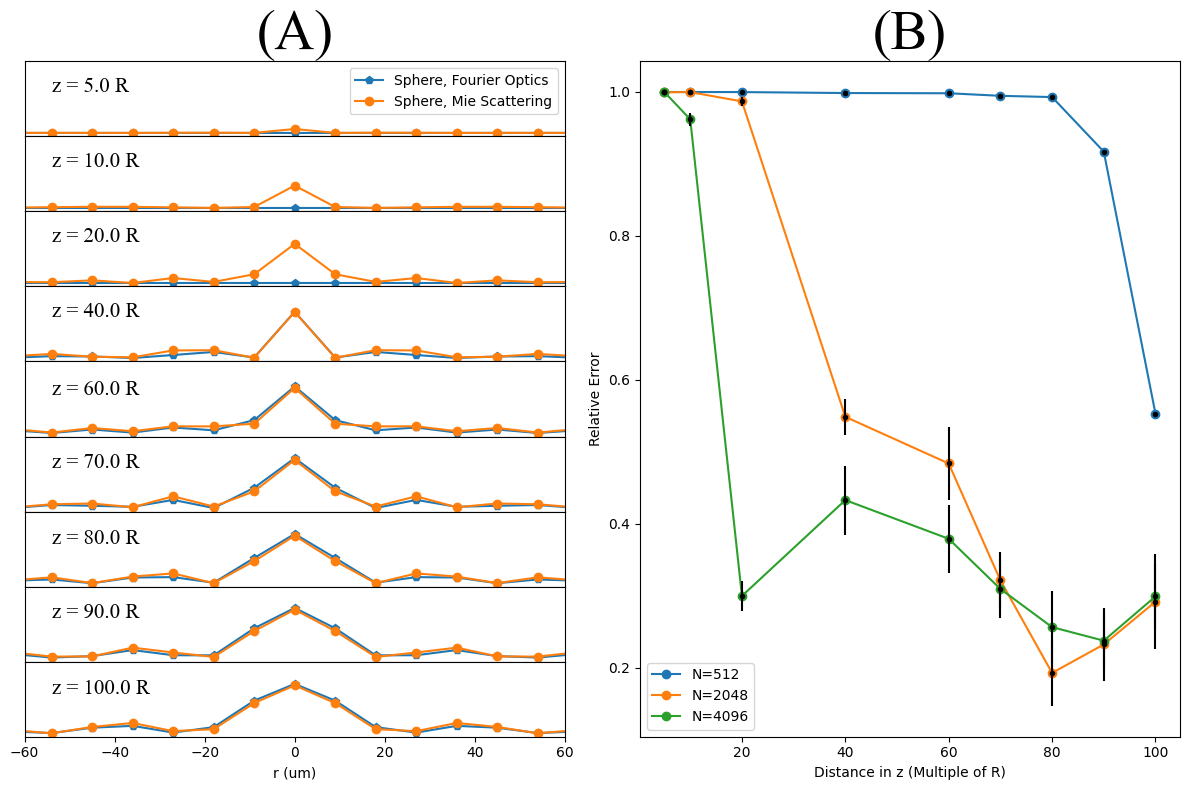

In [11]:
import matplotlib.gridspec as gridspec

# Create the figure and grid specification
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(len(z),2, hspace=0.0)  # Adjust `wspace` to control space between columns

# Create subplots in the first column
for u in range(len(z)):
    ax1 = fig.add_subplot(gs[u, 0])

    # Plot Fourier Optics data
    UU15 = U115[1][u]
    ax1.plot(x0[1], UU15, 'p-', label='Sphere, Fourier Optics')

    # Compute electric field and plot Mie Scattering data
    E_inc = np.array([np.ones(len(xx[1][u])) * np.exp(1j * k * z[u]), np.zeros(len(xx[1][u])), np.zeros(len(xx[1][u]))])
    E = E_inc + EE[1][u]
    UM = abs(E[0])**2 + np.abs(E[1])**2 + np.abs(E[2])**2
    ax1.plot(xx[1][u], UM, 'o-', label='Sphere, Mie Scattering')

    ax1.set_xlim(-b[len(z)-1], b[len(z)-1])  # Ensure consistent x-axis limits
    #ax1.set_ylabel('Intensity')
    ax1.set_yticks([])

    ax1.annotate(f'z = {round(z[u]/R1,2)} R',xy = (0,0),xytext= (-9*b[len(z)-1]/10,0.8), fontname='Times New Roman', fontsize=15   )
    if u == 0:
        ax1.legend()  # Display legend in the first subplot
        ax1.set_title('(A)',fontname='Times New Roman',fontsize=40)
    if u < len(z)-1:
        ax1.set_xticks([])
        ax1.xaxis.set_visible(False)
        ax1.xaxis.set_ticks_position('none')
        

# Make all x-axes share the same properties
plt.setp([fig.axes[i] for i in range(len(z))], xlabel='r (um)')  # Align x-axis labels

# Create subplot in the second column
ax2 = fig.add_subplot(gs[:, 1])
ax2.plot(z//R1, mean_errors5, 'o-', label=f'N={N[0]}')
ax2.errorbar(z//R1, mean_errors5, yerr=mean_std5, fmt='.k')

ax2.plot(z//R1, mean_errors6, 'o-', label=f'N={2048}')
ax2.errorbar(z//R1, mean_errors6, yerr=mean_std6, fmt='.k')

ax2.plot(z//R1, mean_errors7, 'o-', label=f'N={N[2]}')
ax2.errorbar(z//R1, mean_errors7, yerr=mean_std7, fmt='.k')

#ax2.plot(z//R1, mean_errors8, 'o-', label=f'N={N[3]}')
#ax2.errorbar(z//R1, mean_errors8, yerr=mean_std8, fmt='.k')

ax2.legend()
ax2.set_ylabel('Relative Error')
ax2.set_xlabel('Distance in z (Multiple of R)')
ax2.set_title('(B)',fontname='Times New Roman',fontsize=40)

plt.tight_layout()  # Adjusts spacing to prevent overlap
plt.savefig('COMPARAR-ESF-Distancias.png',dpi=300)  # Display the plot